# Description
Notebook to fit linear bias $b1$ by minimizing $\chi^2$ between data and Kaiser's linear theory. For the measurement error, we use a analytic Gaussian covariance matrix as described below. This allows to estimate the data covariance without having to produce many mock catalogs and compute it by brute force.

### Gaussian covariance matrices
Based on Grieb et al. 2016 (https://arxiv.org/pdf/1509.04293.pdf)


Formula for $\chi^2$, for data vector $D=\begin{bmatrix} P_0(k) \\ P_2(k) \end{bmatrix}$, model vector $M=\begin{bmatrix} P^{model}_0(k) \\ P^{model}_2(k) \end{bmatrix}$ and covariance matrix $C$:
$$\chi^2 = \sum_{k bins} (D-M)C^{-1}(D-M)^T$$
With the Gaussian covariance matrix:
$$C=\begin{bmatrix} C_{00} & C_{02} \\ C_{20} & C_{22}\end{bmatrix}, \quad C_{l_1l_2}=diag(\sigma^2_{l_1l_2}(k))$$ 
where $\sigma^2_{l_1l_2}(k)$ is given by eq 15. Note that C is symmetric. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre
from scipy.integrate import simpson
from scipy.linalg import pinv
import scipy.sparse as ss
import cat_power_algos as catpk

import classylss
import classylss.binding as CLASS
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

### Adjust depending on what input file should be used
- MTHOD is a Multi-Tracer Halo Occupation Distribution framework for the galaxy distribution, subsampled to eBOSS density
- AbacusSummit is result of N body simulation for BGS survey

The associated BoySize and cosmology has been extracted from the documentation of these two mock catalogs (https://www.roe.ac.uk/~salam/MTHOD/ and https://abacussummit.readthedocs.io/en/latest/cosmologies.html).

In [3]:
%%time
input_choice = 'MTHOD' #'AbacusSummit'

b1_guess = 0.1
LOS = [0,0,1]
redshift = 0

if input_choice == 'MTHOD':
    BoxSize = 1000
    cosmo = cosmology.Planck15 # couldn't find correct cosmology parameters
    Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
    
    filepath = '/home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat' 
    cat = catpk.make_cat(filepath, cosmo=cosmo, LOS=LOS, z=redshift)
    fname = 'plots/MTHOD_chi2_minimization.pdf'
    
elif input_choice == 'AbacusSummit':
    BoxSize = 2000
    cosmo_paras = classylss.load_ini('Planck18_LCDM.ini')
    cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
    Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
    
    filepath = '/disk11/salam/FirstGenMocks/AbacusSummit/CubicBox/BGS_v2/z0.200/AbacusSummit_base_c000_ph006/BGS_box_ph006.fits'
    cat = FITSCatalog(filepath)
    cat = catpk.prep_fitscat(cat, cosmo=cosmo, LOS=LOS, z=redshift)
    fname = 'plots/AbacusSummit_chi2_minimization.pdf'
    
else:
    raise ValueError("invalid choice")

Loading /home/jwack/power_mockdata/HMQELG-eBOSS-density.gcat
CPU times: user 4.98 s, sys: 403 ms, total: 5.38 s
Wall time: 5.6 s


In [4]:
def kaiser_pkmu(k, mu, b1):
    """Returns power spectrum in redshift space, following Kaiser's linear results."""
    beta = cosmo.scale_independent_growth_rate(redshift) / b1 
    return (1 + beta*mu**2)**2 *b1**2 * Plin(k)


def damped_kaiser_pkmu(k, mu, b1):
    '''Uses phenomenological model to account for non-linearity by damping Kaisers prediction for large k.
    The conventional value of sigma is about 400 km/s.'''
    sigma = np.sqrt(2) # km/s
    return np.exp(-0.5*(sigma*k*mu)**2)*kaiser_pkmu(k, mu, b1)


def make_Pkmu(k, b1):
    '''Make 2D array containing the model P(k,mu) with rows iterating k bins and columns iterating mu bins.
    Later seek to integrate up each row i.e. integrate over mu. Nmu defines the discretiation.'''
    Nmu = 51
    mus = np.linspace(-1,1,Nmu)
    Pkmu = np.empty((len(k), Nmu))
    
    for i,mu in enumerate(mus):
        Pkmu[:,i] = kaiser_pkmu(k,mu,b1)
        
    return Pkmu, mus


def kaiser_multipole(k, ell, b1):
    '''Compute ell-th multipole of Kaiser P(k,mu) by projecting on Legendre polynominal. See eq 3.'''
    Pkmu, mus = make_Pkmu(k, b1)
    L_ell = legendre(ell)(mus)
    integrand = L_ell*Pkmu # each column gets multiplied by value of Legendre poly at assocaiated mu

    return (2*ell+1)/2 * simpson(integrand, mus) # integrate up all rows separtely


def per_mode_cov(k, l1, l2, b1, shotnoise, dk):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. (2016).'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    Pkmu, mus = make_Pkmu(k, b1)
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, ells, b1, shotnoise, dk):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,l1,l2,b1,shotnoise,dk))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    # deal with inverting signular matrix
    try: 
        inv = ss.linalg.inv(cov_mat).toarray()
    except RuntimeError:
        inv = pinv(cov_mat.toarray())
        
    return inv
    
    
def chi2(b1, k, ells, data_multipoles, shotnoise, dk):
    '''Find chi^2 according to markdown. The theoretical Gaussian covariance matrix is used to estimate the data error.'''
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    for i,ell in enumerate(ells):
        model_multipoles[i] = kaiser_multipole(k,ell,b1)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    C_inv = gaussian_cov_mat_inv(k, ells, b1, shotnoise, dk)
    
    return D_M@(C_inv @ D_M)

Find power spectrum up to largest kmax we want to consider. Then perform fitting of b1 by using more and more
bins of the computed power spectrum. Equivalent to computing power spectrum again and again for increasing kmax which
would imply repeating the same computation several times.

In [5]:
ells = [0,2]
k_min = 0
k_max_upper = 0.25
dk = 0.01 # conventional for RSD analysis. Defines bin size in FFTPower
Nmesh = 128

b1_fits, chi2_mins = [], []

print('Painting:')
%time mesh = cat.to_mesh(position='RSDPosition', resampler='tsc', BoxSize=BoxSize, Nmesh=Nmesh, compensated=True)
print('Find power spectrum:')
%time poles = FFTPower(mesh, mode='2d', los=LOS, poles=ells, dk=dk, kmin=k_min, kmax=k_max_upper).poles
k, shotnoise  = poles['k'], poles.attrs['shotnoise']

data_multipoles = np.empty((len(ells), len(k)))

for i,ell in enumerate(ells):
    Pk_ell = poles['power_%d' %ell].real
    if ell == 0: 
        Pk_ell = Pk_ell - shotnoise
    data_multipoles[i] = Pk_ell

for i in range(len(k)):
    t1 = time.time()
    s = minimize(chi2, b1_guess, args=(k[:i+1], ells, data_multipoles[:,:i+1], shotnoise, dk))
    b1_fits.append(s.x[0])
    chi2_mins.append(s.fun)
    
    t2 = time.time()
    print("Finished kmax={:.3f} in t={:.2f} seconds".format(k[i], t2-t1))

Painting:
CPU times: user 4.58 ms, sys: 19.4 ms, total: 24 ms
Wall time: 73.6 ms
Find power spectrum:
CPU times: user 520 ms, sys: 565 ms, total: 1.08 s
Wall time: 1.1 s
Finished kmax=0.008 in t=0.69 seconds
Finished kmax=0.017 in t=0.59 seconds
Finished kmax=0.026 in t=0.72 seconds
Finished kmax=0.035 in t=0.67 seconds
Finished kmax=0.045 in t=0.69 seconds
Finished kmax=0.056 in t=0.68 seconds
Finished kmax=0.065 in t=0.63 seconds
Finished kmax=0.075 in t=2.99 seconds
Finished kmax=0.085 in t=0.70 seconds
Finished kmax=0.095 in t=0.70 seconds
Finished kmax=0.105 in t=2.98 seconds
Finished kmax=0.115 in t=3.20 seconds
Finished kmax=0.125 in t=3.19 seconds
Finished kmax=0.135 in t=0.67 seconds
Finished kmax=0.145 in t=0.68 seconds
Finished kmax=0.155 in t=0.66 seconds
Finished kmax=0.165 in t=4.92 seconds
Finished kmax=0.175 in t=2.99 seconds
Finished kmax=0.185 in t=3.13 seconds
Finished kmax=0.195 in t=3.55 seconds
Finished kmax=0.205 in t=3.96 seconds
Finished kmax=0.215 in t=3.55 se

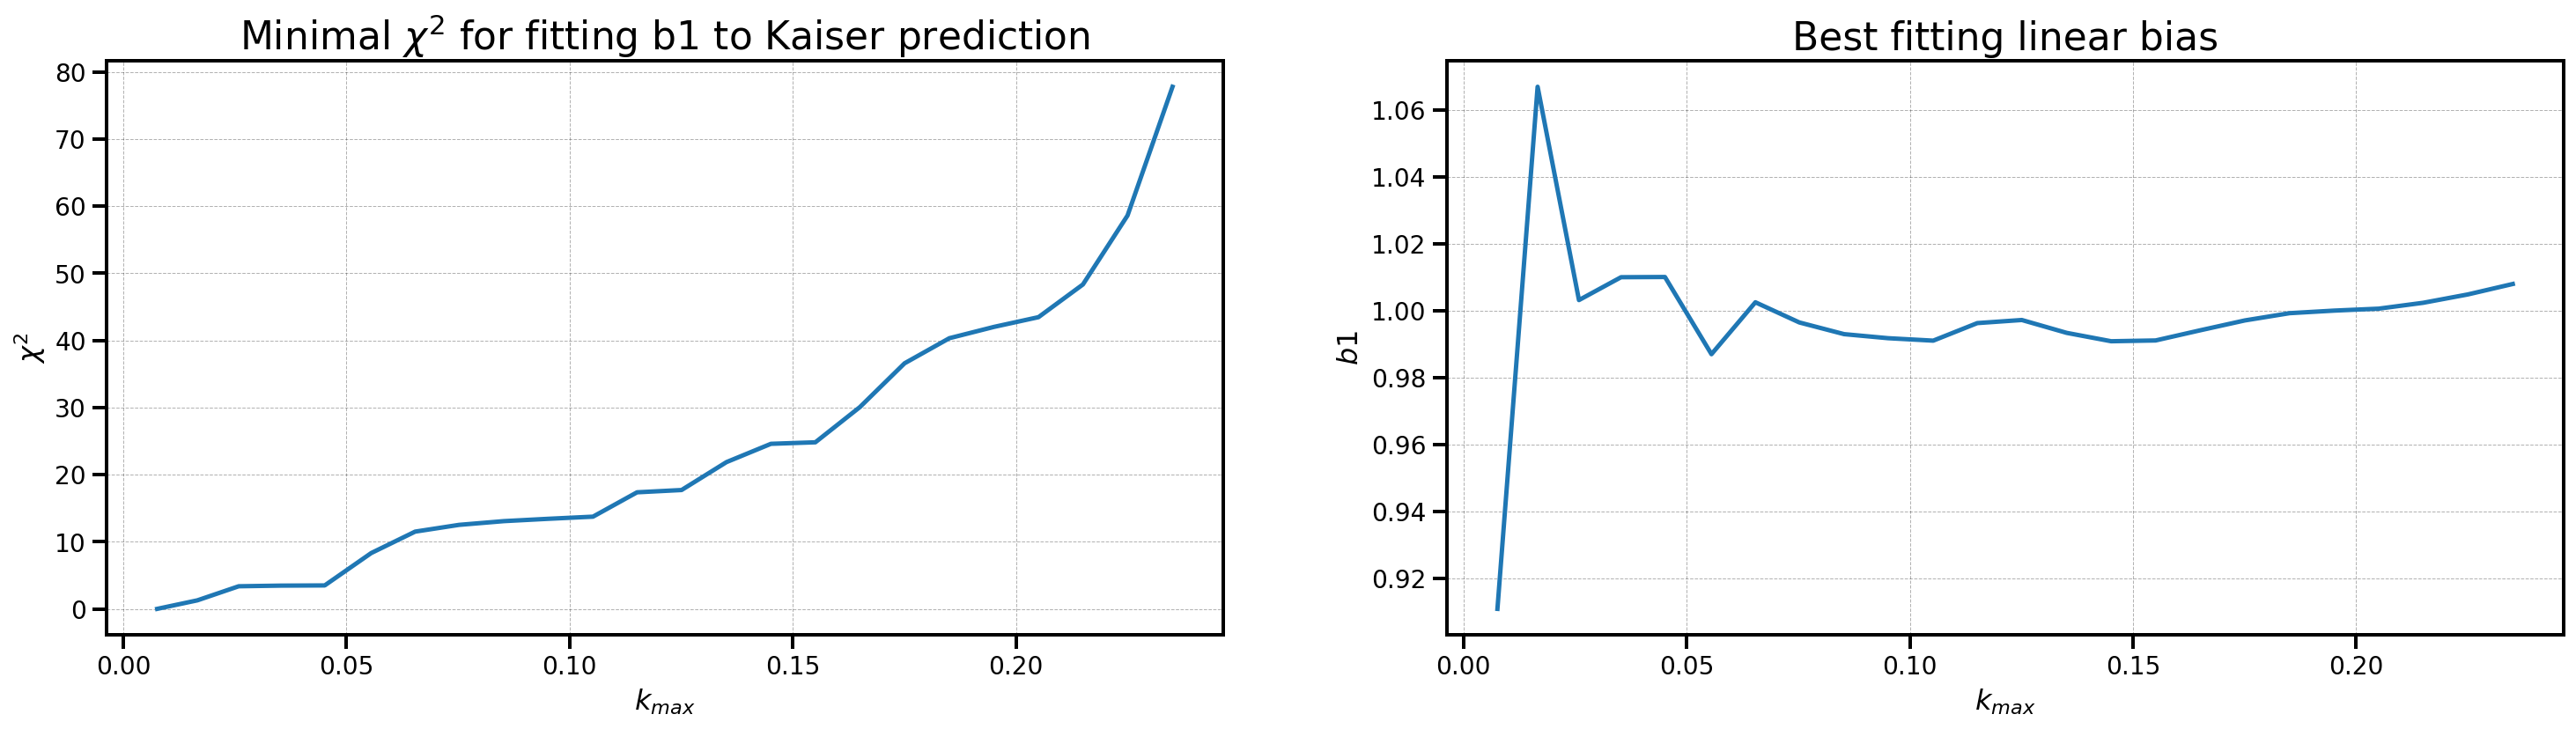

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,6))

ax1.plot(k, chi2_mins)
ax1.set_title('Minimal $\chi^2$ for fitting b1 to Kaiser prediction')
ax1.set_xlabel('$k_{max}$')
ax1.set_ylabel('$\chi^2$')

ax2.plot(k, b1_fits)
#ax2.set_yscale('log')
ax2.set_title('Best fitting linear bias')
ax2.set_xlabel('$k_{max}$')
ax2.set_ylabel('$b1$')

plt.show()
fig.savefig(fname)

### Interpretation
Larger `kmax` means we further enter into the non-linear regime. Hence we expect $\chi^2$ to grow. Trying to account for the power spectrum damping due to RSD by modeling Kaiser's prediction with a Gaussian (common first order correction) is unsuccessful. One needs change calls of kaiser_pkmu to damped_kaiser_pkmu with:
```
def damped_kaiser_pkmu(k, mu, b1):
    '''Uses phenomenological model to account for non-linearity by damping Kaisers prediction for large k.
    The conventional value of sigma is about 400 km/s.'''
    sigma = np.sqrt(2) # km/s
    return np.exp(-0.5*(sigma*k*mu)**2)*kaiser_pkmu(k, mu, b1)
```

For the considered mock catalogs we expect $b1$ close to 1.

### Extra plots

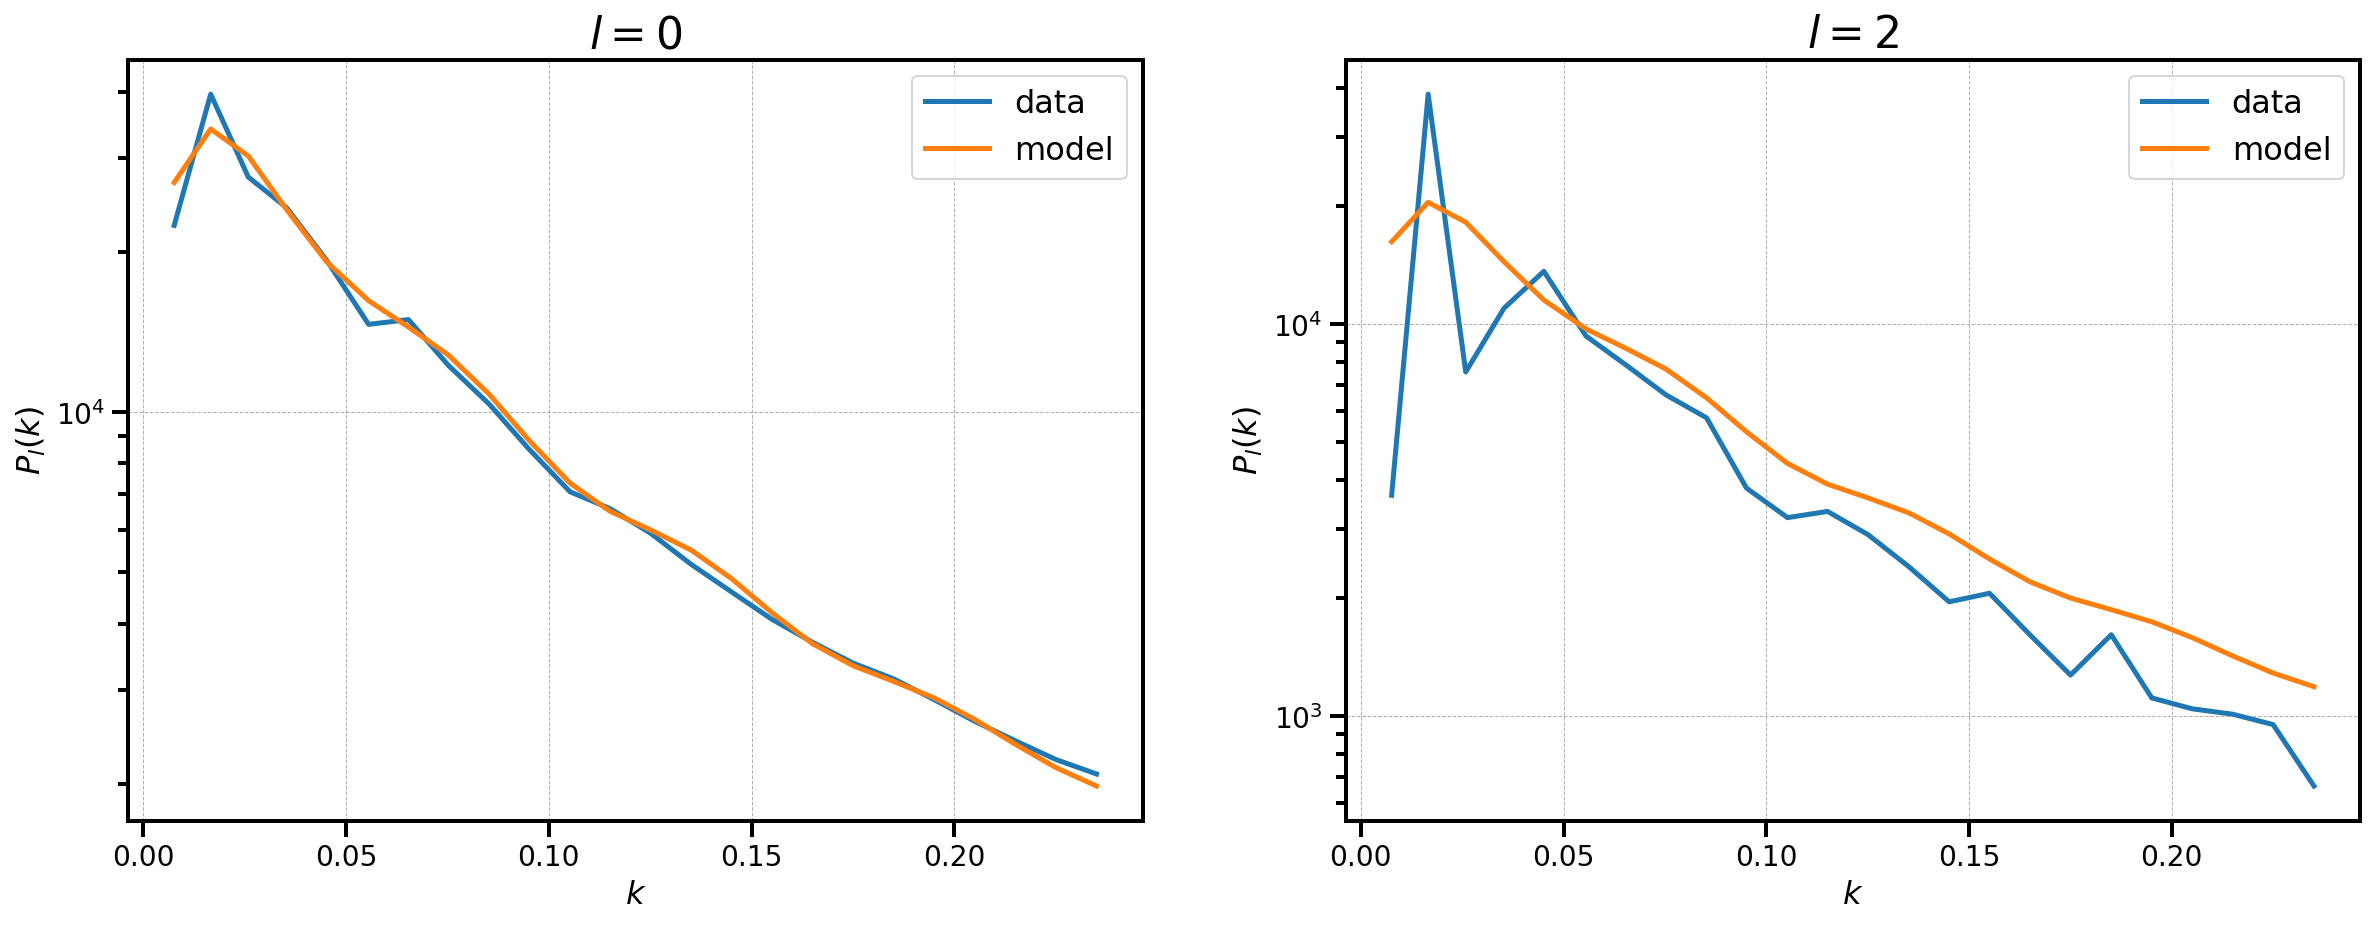

In [7]:
# Compare data and model multipoles
model_multipole = np.empty((len(ells), len(k)))
for i,ell in enumerate(ells):
    model_multipole[i] = kaiser_multipole(k,ell,b1_fits[-1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

ax1.set_title('$l=0$')
ax1.plot(k, data_multipoles[0], label='data')
ax1.plot(k, model_multipole[0], label='model')
ax1.set_yscale('log')
ax1.set_xlabel('$k$')
ax1.set_ylabel('$P_l(k)$')
ax1.legend()

ax2.set_title('$l=2$')
ax2.plot(k, data_multipoles[1], label='data')
ax2.plot(k, model_multipole[1], label='model')
ax2.set_yscale('log')
ax2.set_xlabel('$k$')
ax2.set_ylabel('$P_l(k)$')
ax2.legend()

plt.show()

/tmp/ipykernel_4073857/601372284.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ratio = np.asarray(chi2_mins) / (n_kbins-1)


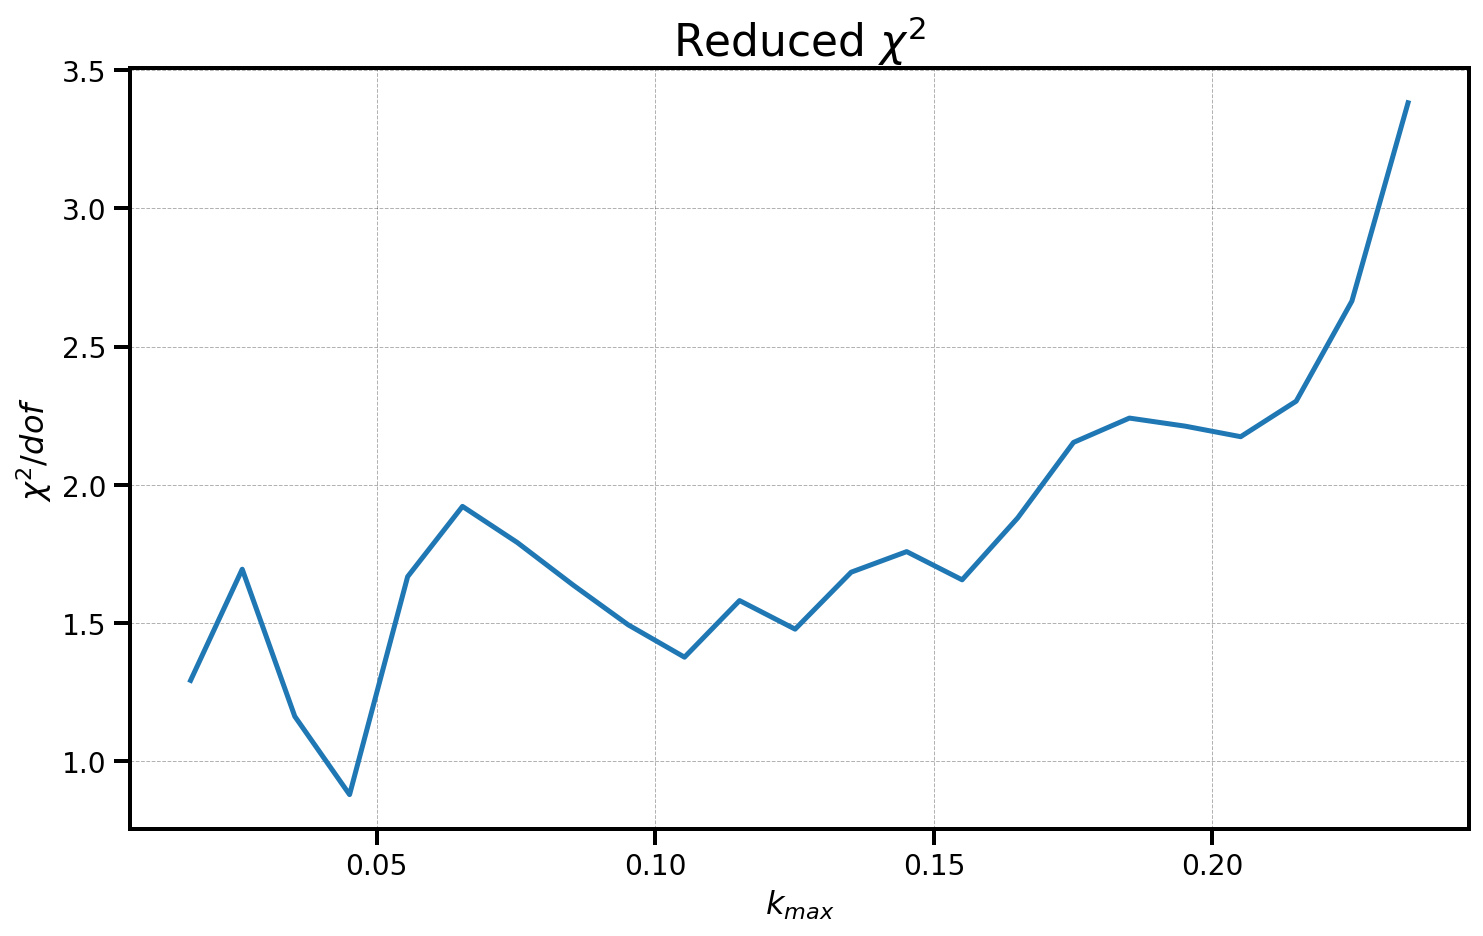

In [17]:
# Compute reduced chi2: number of k bins - number of free parameters (only b1 in this case)
n_kbins = np.arange(1,len(k)+1)
ratio = np.asarray(chi2_mins) / (n_kbins-1)

fig = plt.figure()
plt.plot(k[1:], ratio[1:])
plt.xlabel('$k_{max}$')
plt.ylabel('$\chi^2 / dof$')
plt.title('Reduced $\chi^2$')
#fig.savefig("plots/MTHOD_reduced_chi2.pdf")